Credit: https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

In [0]:
#Install extra lib(s)
!pip install -q xlrd
!pip install -q kaggle
!pip install -q kora

import kora
import pandas as pd

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import *


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


#Getting Dataset

https://www.kaggle.com/rouseguy/bankbalanced/data

In [0]:
%pip install opendatasets --upgrade

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/rouseguy/bankbalanced/data","/dbfs/FileStore/mypath/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  pasdputthapipat

Your Kaggle Key:

  [REDACTED]

100%|██████████| 142k/142k [00:00<00:00, 1.75MB/s]

In [0]:
%sh ls /dbfs/FileStore/mypath/bankbalanced

bank.csv


--%sh unzip /dbfs/FileStore/mypath/bankbalanced

#Exploring Data

##Schema

In [0]:
file_path = "file:/dbfs/FileStore/mypath/bankbalanced/bank.csv"
df_input = spark.read.options(header="true",inferschema = "true").csv(file_path)

df_input.printSchema()

df_input.show()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)

+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|        job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+----

##Target balanceness

In [0]:
df_input.groupby("deposit").count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



## Numerical Statistic

In [0]:
numeric_features = [t[0] for t in df_input.dtypes if t[1] == 'int']
df_input.select(numeric_features).describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|           balance|               day|          duration|          campaign|             pdays|          previous|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             11162|             11162|             11162|             11162|             11162|             11162|             11162|
|   mean|41.231947679627304|1528.5385235620856|15.658036194230425|371.99381831213043| 2.508421429851281| 51.33040673714388|0.8325568894463358|
| stddev|11.913369192215518| 3225.413325946149| 8.420739541006462|347.12838571630687|2.7220771816614824|108.75828197197717| 2.292007218670508|
|    min|                18|             -6847|                 1|                 2|                 1|                -1|                 0|

##Correlation

In [0]:
#Select only numerical data
df_input_num = df_input.select(numeric_features)
numeric_data = df_input.select(numeric_features).toPandas()

In [0]:
#Additional example
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_input_num.columns, outputCol=vector_col)
df_vector = assembler.transform(df_input_num).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

matrix.collect()[0]["pearson({})".format(vector_col)].values

array([ 1.00000000e+00,  1.12299889e-01, -7.62420921e-04,  1.89228074e-04,
       -5.27793616e-03,  2.77383431e-03,  2.01685612e-02,  1.12299889e-01,
        1.00000000e+00,  1.04674395e-02,  2.24361313e-02, -1.38938225e-02,
        1.74111486e-02,  3.08052469e-02, -7.62420921e-04,  1.04674395e-02,
        1.00000000e+00, -1.85113992e-02,  1.37006834e-01, -7.72316130e-02,
       -5.89806835e-02,  1.89228074e-04,  2.24361313e-02, -1.85113992e-02,
        1.00000000e+00, -4.15574588e-02, -2.73915532e-02, -2.67161713e-02,
       -5.27793616e-03, -1.38938225e-02,  1.37006834e-01, -4.15574588e-02,
        1.00000000e+00, -1.02726048e-01, -4.96994980e-02,  2.77383431e-03,
        1.74111486e-02, -7.72316130e-02, -2.73915532e-02, -1.02726048e-01,
        1.00000000e+00,  5.07271588e-01,  2.01685612e-02,  3.08052469e-02,
       -5.89806835e-02, -2.67161713e-02, -4.96994980e-02,  5.07271588e-01,
        1.00000000e+00])

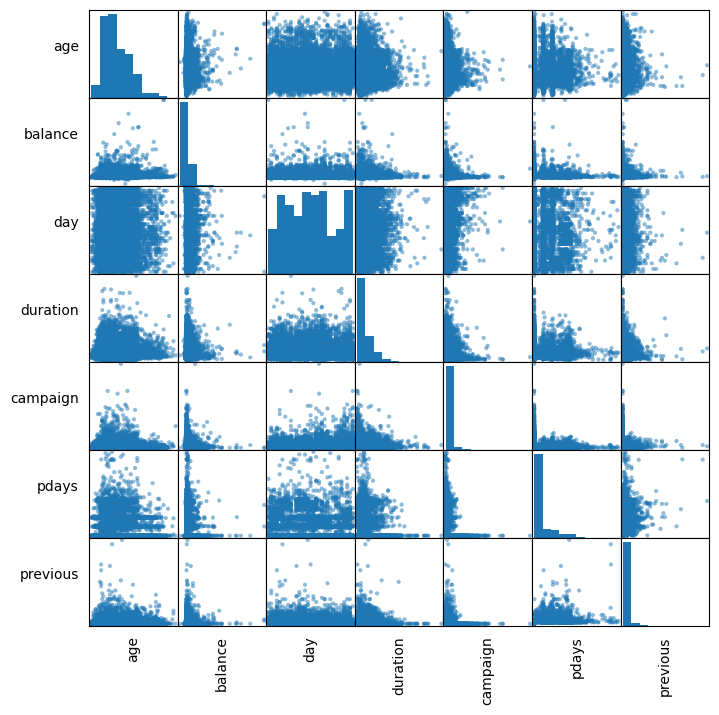

In [0]:
from pandas.plotting import scatter_matrix

axs = scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

##Select high corelate features

In [0]:
df = df_input.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



#Prepare data (for model)
The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column.

In [0]:
from pyspark.ml.feature import *
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [0]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [0]:
df.show(5)

+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+
|label|            features|age|       job|marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|deposit|
+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+
|  1.0|(30,[3,11,13,16,1...| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|    1042|       1|   -1|       0| unknown|    yes|
|  1.0|(30,[3,11,13,16,1...| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|    1467|       1|   -1|       0| unknown|    yes|
|  1.0|(30,[2,11,13,16,1...| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|    1389|       1|   -1|       0| unknown|    yes|
|  1.0|(30,[4,11,13,16,1...| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|     579

In [0]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


#Logistic Regression Model

##Model trainning

In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

##Beta exploration

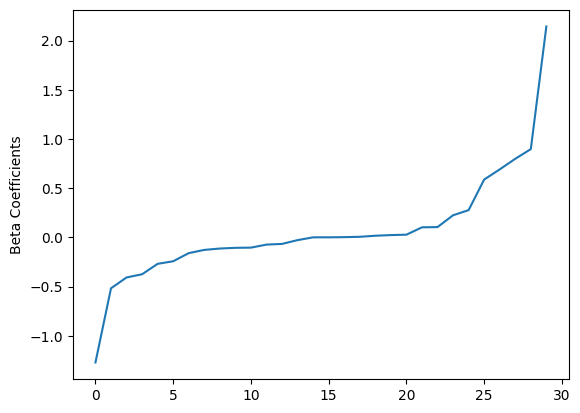

In [0]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

##ROC (receiver-operating characteristic)

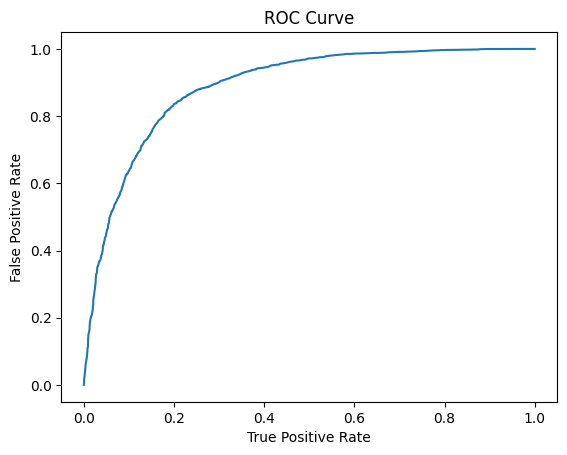

Training set areaUnderROC: 0.8877385690600346


In [0]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))


##Precision and recall.

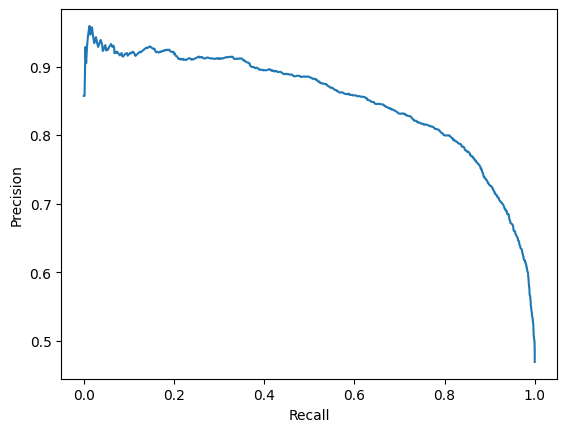

In [0]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [0]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.93084854518134...|       0.0|[0.87334331124860...|
| 49|management|  0.0|[1.92783695472104...|       0.0|[0.87300981013434...|
| 52|management|  0.0|[-0.7737627890180...|       1.0|[0.31566570209269...|
| 53|management|  0.0|[0.94708137344080...|       0.0|[0.72052784002181...|
| 58|management|  0.0|[2.44657764692465...|       0.0|[0.92031082026377...|
| 32|management|  0.0|[1.28386077546043...|       0.0|[0.78310624913887...|
| 57|management|  0.0|[1.05745870556538...|       0.0|[0.74220460119093...|
| 52|management|  0.0|[3.25200815517468...|       0.0|[0.96274520587479...|
| 46|management|  0.0|[2.24978402804244...|       0.0|[0.90463190417563...|
| 31|management|  0.0|[1.47121751117281...|       0.0|[0.81324237120149...|
+---+-------

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.885643189559481


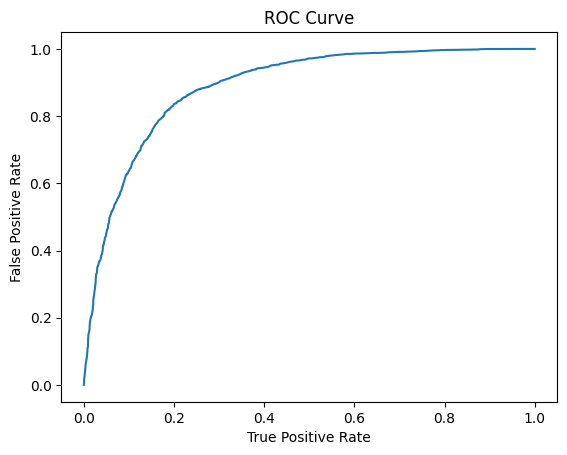

Training set areaUnderROC: 0.8877385690600346


In [0]:
testSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

#Other Model Example

##Decision Tree Classifier

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 33|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 49|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[520.0,1931.0]|       1.0|[0.21215830273357...|
| 53|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 58|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 32|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 57|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 46|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 31|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [0]:

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7808118726917547


In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7808118726917547


##Random Forest Classifier

In [0]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[15.1732289538056...|       0.0|[0.75866144769028...|
| 49|management|  0.0|[14.8720206812358...|       0.0|[0.74360103406179...|
| 52|management|  0.0|[6.41037265943282...|       1.0|[0.32051863297164...|
| 53|management|  0.0|[13.9791686762029...|       0.0|[0.69895843381014...|
| 58|management|  0.0|[15.0765159080026...|       0.0|[0.75382579540013...|
| 32|management|  0.0|[14.6040792750470...|       0.0|[0.73020396375235...|
| 57|management|  0.0|[14.4561117618228...|       0.0|[0.72280558809114...|
| 52|management|  0.0|[16.5816565336194...|       0.0|[0.82908282668097...|
| 46|management|  0.0|[16.0099055376847...|       0.0|[0.80049527688423...|
| 31|management|  0.0|[15.4434224763436...|       0.0|[0.77217112381718...|
+---+-------

In [0]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8788987564396561


##Gradient-Boosted Tree Classifier

In [0]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[0.94992370947246...|       0.0|[0.86987425549896...|
| 49|management|  0.0|[1.28281748604659...|       0.0|[0.92861688965145...|
| 52|management|  0.0|[-0.5021429054421...|       1.0|[0.26809961471379...|
| 53|management|  0.0|[0.09646513340517...|       0.0|[0.54808351175538...|
| 58|management|  0.0|[1.05831377292163...|       0.0|[0.89250881497055...|
| 32|management|  0.0|[0.57268875896254...|       0.0|[0.75866558918304...|
| 57|management|  0.0|[0.34932946844840...|       0.0|[0.66789037418062...|
| 52|management|  0.0|[1.33264456943866...|       0.0|[0.93494709840561...|
| 46|management|  0.0|[1.28262818068783...|       0.0|[0.92859178839697...|
| 31|management|  0.0|[1.16094954405484...|       0.0|[0.91067454521219...|
+---+-------

In [0]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8935091626908479


In [0]:
print(gbt.explainParams())


cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

Further reading: https://spark.apache.org/docs/latest/ml-classification-regression.html